# Regime filters

A regime filter is a classification to indicate the market condition we are in. They could provide some useful pointers to improve trading results. Though we cannot predict the market movements with certainty, we can atleast get an edge.

We should keep these filters simple so that it is easy to understand and do not overfit too much to available data. Boolean filters are a good choice since they only have a true or false value and not prone to too much overfitting, though they may only have a slight edge.

## A simple price filter

Let us a simple price filter.

1. Create a moving average of the price for the last 60 days.
2. If the close price is greater than the average price, give it a value of 1.
3. If the close price is less than the average price, give it a value of 0
    
We shift the average price by 1 day so that we do not include today's close price 

<!-- TEASER_END -->

In [1]:
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
# parameters
ma = 60

In [3]:
df = pd.read_csv('/home/pi/data/sp500.csv', parse_dates=['Date']).rename(
columns = lambda x:x.lower()).sort_values(by='date').set_index('date')
df['ret'] = df.close.pct_change()
df.tail()

,open,high,low,close,volume,adj close,ret
date,,,,,,,
2021-11-24,4675.779785,4702.870117,4659.890137,4701.459961,2464040000,4701.459961,0.002294
2021-11-26,4664.629883,4664.629883,4585.430176,4594.620117,2676740000,4594.620117,-0.022725
2021-11-29,4628.750000,4672.950195,4625.259766,4655.270020,3471380000,4655.270020,0.013200
2021-11-30,4640.250000,4646.020020,4560.000000,4567.000000,4950190000,4567.000000,-0.018961
2021-12-01,4602.819824,4652.939941,4510.270020,4513.040039,4078260000,4513.040039,-0.011815


In [4]:
df['ma_price'] = df.close.rolling(ma).mean().shift(1)
df['is_price'] = df.eval('close > ma_price')+0
df['is_price'] = df.is_price.shift(1) # Shifting price since we use the signal only next day

In [5]:
df.groupby(['is_price']).ret.describe()

,count,mean,std,min,25%,50%,75%,max
is_price,,,,,,,,
0.0,1889.0,0.000423,0.017703,-0.119841,-0.008244,0.000956,0.009203,0.115800
1.0,3626.0,0.000206,0.008350,-0.058944,-0.003560,0.000547,0.004686,0.038053


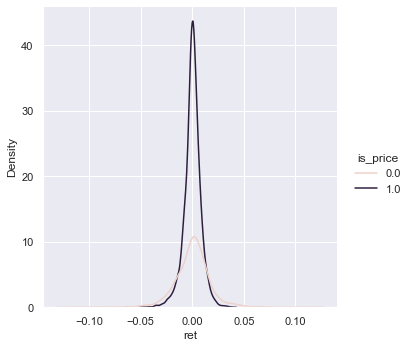

In [6]:
sns.displot(data=df, x='ret', hue='is_price', kind='kde')

Looks there seem to be an edge when the filter is negative where the returns are a bit more.

~~In the earlier version, I computed the end of the day returns which is obvious and just a explanation of events already happened. Forward returns should always be considered to find a predictive edge.~~


<div class="alert alert-warning">
    This doesn't seem like a tradeable edge since the margin is very small
    </div>

Let us see whether the edge persists through all years.


<AxesSubplot:title={'center':'Mean returns by year'}, xlabel='year'>

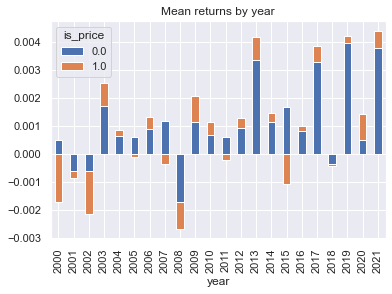

In [7]:
df['year'] = df.index.year
df.groupby(['year', 'is_price']).ret.mean().unstack().plot.bar(stacked=True, 
                                                               title="Mean returns by year")

The edge fairly persists over the years.

Let us try changing it to median and see if it improves the results


In [8]:
df['ma_price'] = df.close.rolling(ma).median().shift(1)
df['is_price'] = df.eval('close > ma_price')+0
df['is_price'] = df.is_price.shift(1) # Shifting price since we use the signal only next day
df.groupby(['is_price']).ret.describe()

,count,mean,std,min,25%,50%,75%,max
is_price,,,,,,,,
0.0,1950.0,0.000485,0.017500,-0.119841,-0.008144,0.000953,0.009326,0.115800
1.0,3565.0,0.000168,0.008332,-0.058944,-0.003545,0.000546,0.004628,0.038053


Not so big. This is just a simple way to create a filter to define a market environment and see how it impacts the returns. The following could be done to improve a filter

 * Use quantiles instead of mean or median
 * Calculate the filter for different moving averages
 * Try simulating for periods instead of rolling over averages